In [16]:
import pickle
import numpy as np
import sys,os
from util import *

# Upload example data 

In [2]:
inputs={}
neighs={}

# input_sample_poi[chromosome] returns an array which reflect the genomic location for each sample
# input_sample_poi[chromosome][seq_idx] returns a scalar which is the start position of the corresponding 200-bp sequence
with open('examples/input_sample_poi.pickle','rb') as f:
  input_sample_poi=pickle.load(f)

with open('chromatin_feature.pickle','rb') as f:
  chromatin_feature=pickle.load(f)
inputs[21]= np.load('examples/echo/chr21.npy')

# get the first 100 samples from chr21 to run an example
neighs[21]= np.load('examples/neighbors_chr21.npy')[:100,:]

# Run model
calculate the prediction scores of all 2583 chromatin features (882 TFs,1510 HMs and 191 DHSs)

Notice:
1. The contacts and neighbor sequences are attributed according to the TFs which have prediction scores greater than the set 'threshold' due to the unknown true label.
2. The outputs of attribution score results (especially the attribution scores on neighbor sequences) are large, please use small input sample size at a time if you use local machine.
You can choose not to compute the attribution scores by setting 'attribute_neigh_contact = False' or only attribute the contacts by setting 'attribute_neigh = False'.
3. The neighbor sequences are attributed when the corresponding chromatin contacts have attribution score greater than the set 'attr_threshold'.

In [5]:
# prediction_scores[chromosome] returns a (input sample size*2583) matrix
# att_contacts[chromosome][central_seq_idx][neighbor_seq_idx] returns a scalar of attribution score on corresponding chromatin contact
# att_neighs[chromosome][central_seq_idx][neighbor_seq_idx] returns a (4*1000) matrix which is the attribution scores on neighbor sequences

prediction_scores, att_contacts, att_neighbors = echo_attribute(inputs,neighs,threshold=0.2,attr_threshold=0.3,
                                      attribute_neigh_contact = True,attribute_neigh =True)

cuda:0
step: 0001 time= 0.54777


# Prediction scores on central sequence

In [6]:
example_chr=21

# select a central sequence from the inputs for analysis
# you can find the genomic location by 'input_sample_poi[example_chr][central_seq_idx]'
central_seq_idx=60

print("The selected central sequence is %s-%sbp with 400 bp " 
"flanking region both upstream and downstream \n"
%(input_sample_poi[example_chr][central_seq_idx],input_sample_poi[example_chr][central_seq_idx]+200))

# report the top 10 TFs with highest prediction scores
# prediction scores (0~1) are the outputs of ECHO, which predict the chromatin features on central sequence

number_TF=882
top_tf=10
print('Top 10 TFs with highest prediction scores')
TF_indices=np.argsort(prediction_scores[example_chr][central_seq_idx,:number_TF])[::-1][:top_tf]
for idx in TF_indices:
  print(chromatin_feature[idx],prediction_scores[example_chr][central_seq_idx,idx])

The selected central sequence is 5220400-5220600bp with 400 bp flanking region both upstream and downstream 

Top 10 TFs with highest prediction scores
CTCF	C4-2B 0.38519776
CTCF	22Rv1 0.33914116
CTCF	RWPE2 0.33469218
CTCF	Panc1 0.323666
CTCF	epithelial_cell_of_prostate 0.2753478
CTCF	VCaP 0.18153824
CTCF	OCI-LY7 0.1193593
CTCF	SK-N-SH 0.07425023
SUPT5H	K562 0.071850136
CTCF	RWPE1 0.07134712


# Attribution scores on chromatin contacts

In [7]:
# The attribution scores reflect the importance of the corresponding sequence to the prediction of TF binding on the central sequence.
# Typically, the central sequence itself has the largest attribution scores

# if all the prediction scores of TF binding are below the set threshold, then the contacts and neighbor sequences will not be attributed

neighbor_sequences=[]

if 'None' not in att_contacts[example_chr][central_seq_idx].keys():
  # return the indices of neighbor sequences
  neighbor_sequences=list(att_contacts[example_chr][central_seq_idx].keys())
  sorted_neighbors= sorted(att_contacts[example_chr][central_seq_idx].items(), key=lambda item: item[1])[::-1]
  print("sequence: sequences that contact with the central sequence. \nindex: the corresponding index of the sequence.\n"
  "distance: contact distance with the central sequence \nscore: corresponding attribution score on the chromatin contact \n")

  for n in sorted_neighbors:
    print('sequence: %s, index %s, distance %s, score: %s'%(input_sample_poi[example_chr][n[0]],n[0],input_sample_poi[example_chr][n[0]]-input_sample_poi[example_chr][central_seq_idx],n[1]))

else:
  print("No prediction scores for TF binding on the central sequence exceeds the set threshold")


sequence: sequences that contact with the central sequence. 
index: the corresponding index of the sequence.
distance: contact distance with the central sequence 
score: corresponding attribution score on the chromatin contact 

sequence: 5218600, index 58, distance -1800, score: 1.0
sequence: 5220400, index 60, distance 0, score: 0.9598853588104248
sequence: 5220800, index 62, distance 400, score: 0.7834067940711975
sequence: 5220600, index 61, distance 200, score: 0.5656781196594238
sequence: 5220200, index 59, distance -200, score: 0.40355437994003296
sequence: 5218400, index 57, distance -2000, score: 0.36771437525749207
sequence: 5221400, index 65, distance 1000, score: 0.14128367602825165
sequence: 5217200, index 55, distance -3200, score: 0.09224063903093338
sequence: 5221600, index 66, distance 1200, score: 0.07742934674024582
sequence: 5221000, index 63, distance 600, score: 0.06369572877883911
sequence: 5227200, index 75, distance 6800, score: 0.0621546246111393
sequence: 522

# Attribution scores on neighbor sequences

[57, 58, 59, 60, 61, 62]
[58, 60, 62, 61, 59, 57, 65, 55, 66, 63, 75, 64, 56]
[5218600, 5220400, 5220800, 5220600, 5220200, 5218400, 5221400, 5217200, 5221600, 5221000, 5227200, 5221200, 5217400]
The selected central sequence is 5220400-5220600bp with 400 bp flanking region both upstream and downstream 



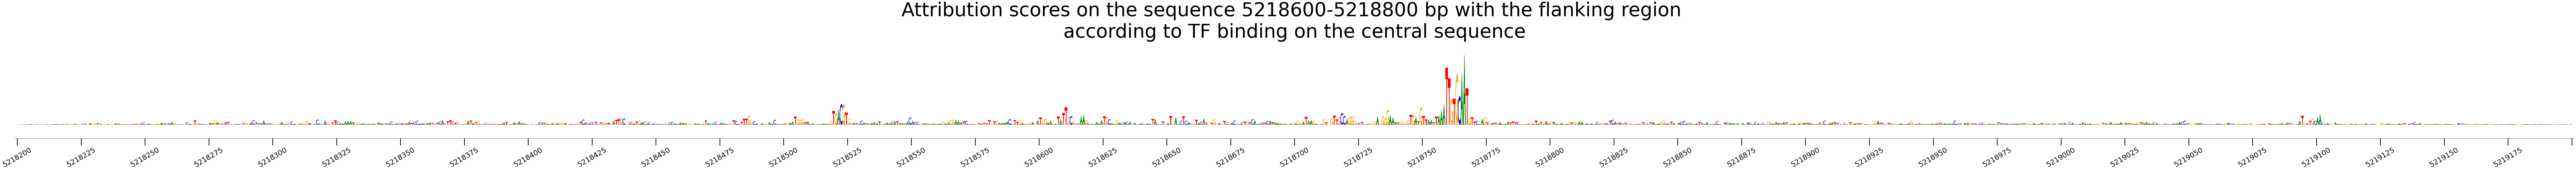

In [15]:
if neighbor_sequences:
  neighbors_abovethreshold=list(att_neighbors[example_chr][central_seq_idx].keys())
  print(neighbors_abovethreshold)
  sorted_neighbors= sorted(att_contacts[example_chr][central_seq_idx].items(), key=lambda item: item[1])[::-1]
  sorted_neighbors=[n[0] for n in sorted_neighbors]
  print(sorted_neighbors)
  
  print([input_sample_poi[example_chr][n] for n in sorted_neighbors])
  print("The selected central sequence is %s-%sbp with 400 bp " 
        "flanking region both upstream and downstream \n"
        %(input_sample_poi[example_chr][central_seq_idx],input_sample_poi[example_chr][central_seq_idx]+200))
  
  # choose a neighbor sequence to visualize its attribution score according to TF binding on the central sequence
  neighbor_seq_idx=58
  plot_weights(att_neighbors[example_chr][central_seq_idx][neighbor_seq_idx],input_sample_poi[example_chr][neighbor_seq_idx])